Catturare le variazioni del mercato è importante per le decisioni da prendere sul nostro portafoglio.
Ad esempio è intuitivo aumentare l'esposizione al rischio quando questo è più gratificante, ora catturare questo è leggermente complicato.

Esiste un modo robusto per modellare queste dipendenze temporali, cercando di ricondurle ad un piccolo numero di differenti regimi.

Ora la domanda, cosa intendiamo per regime?

Per regime intendiamo un periodo di tempo in cui le caratteristiche delle performance del mercato e le relative attività economiche sono ragionevolmente stabili.

Dobbiamo anche capire una criticità dei modelli di simulazione che abbiamo usato che assumono che la distribuzione dei rendimenti sia normale, in realtà abbiamo il problema della coda lunga (eventi rari ma molto negativi).

Inoltre durante i periodi di crash del mercato tutte le tipologie di assett del mercato tendono ad avere una forte correlazione.

La nostra idea dunque è quella di costruire un portafoglio che possa comportarsi bene nelle due fasi di regime 

## Prendere decisioni con condizioni di mercato mutevoli

Quello che dobbiamo avere bene a mente è che rischio e rendimento non sono costanti nel tempo.
Catturare dunque le variazioni cicliche del mercato è decisivo per migliorare il nostro portafoglio esistono diversi metodi per fare ciò:

* Analisi del tipo finestra scorrevole
* Media esponenziale scorrevole
* Modelli Garch
* Modelli di cambio regime

Iniziamo con la stima più semplice, qui sotto la formula impostiamo il rendimento al tempo $t$ come:

$$
    R_{t} = \frac{V_{t} - V_{t-1}}{V_{t-1}} 
$$

Impostiamo $\sigma_{t}^{2}$ come:

$$
    \sigma_{T}^{2} = \frac{1}{T - 1} \sum_{t=1}^{T}\left( R_{t} - \bar{R}_{T} \right)^{2}
$$

Nella pratica per semplicità impostiamo $\bar{R}_{T}$ a 0

Come passo successivo possiamo usare modelli con pesi infatti è corretto dare peso maggiore alla volatilità a noi più vicina.
Si passa dunque alla media esponenziale in cui i pesi della media sono impostati come:

$$
    \alpha_{t} = \frac{\lambda^{T-t}}{\sum_{t=1}^{T} \lambda^{T-t}}
$$

Più basso sarà il valore di $\lambda$  più i valori recenti avranno peso


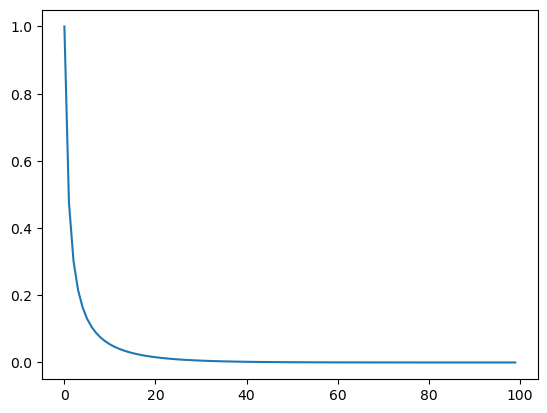

In [1]:
import numpy as np
import matplotlib.pyplot as plt

lam = 1.1
T = 100
t = np.arange(0,T)

temp = lam ** (T - t)
alpha = (temp) / (np.cumsum(temp))
plt.plot(alpha)

Si passa poi ad un modello [ARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) che mescolano la varianza del lungo periodo $V_L$ con la media pesata.

$$
    \sigma_{T}^{2} = \gamma V_L + \sum_{t=1}^{T} \alpha_t R_t^2
$$

Con il vincolo 

$$
    \gamma + \sum_{t=1}^{T} \alpha_t = 1
$$


Si passa poi ai modelli GARCH che oltre ad avere nella parte della formula i rendimenti passati usa anche le volatilità passate:

$$
    \sigma_{T}^{2} = \gamma V_L + \alpha R_{T}^2 + \beta \gamma_{T-1}^2
$$

Con i vincoli:

$$
    \gamma + \alpha + \beta = 1
$$

L'idea è quella di catturare una certa continità del marcato.

Possiamo poi passare ai modelli di stato nei quali invece di catturare le variazioni temporali si passa alla analisi delle dipendenze dello stato al variare dei parametri.

In questa modellazione possiamo creare degli stati e su di essi creare una matrice di transizione.

Creiamo ad esempio due stati, **Alta Volatilità** e **Bassa Volatilità**


## Approccio trend filtering

Volgiamo filtrare i dati in nostro possesso ad esempio l'indice sp500 al fine di perseguire due obiettivi:

* avere una curva senza troppe fluttuazioni
* non essere troppo lontani dal dato in origine


\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

con

\begin{equation*} 
D =
    \begin{bmatrix}
       1 & -2 & 1 & \dots & 0 & 0  \\
       0  & 1 &-2 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -2 & -1\\
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
\end{equation*}

Come si vede la funzione obiettivo è composta da due parti:

* la prima una interpolazione quadratica serve a far si che i punti di origine e i punti della nostra interpolazione non siano troppo distanti

* la seconda parte invece gestita dalla matrice $D$ fa si che il valore interpolato $\lambda_t$ e $\lambda_{t+1}$ abbiamo la minor distanza possibile questo serve per ottenere una curva più dolce

Il parametro $\lambda$ serve a gestire quanto questa curva deve essere dolce:

* con $\lambda$ = 0 i valori interpolati $\beta$ e $x$ saranno identici
* con $\lim_{\lambda \to \infty}$ i valori interpolati saranno una retta 

vediamo il codice di implementazione



In [2]:
n = 10

Dfull = -np.diag([2]*n) + np.diag([1]*(n-1),1) +  np.diag([1]*(n-1),-1)
D = Dfull[0:(n-1),]
Dfull

array([[-2,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -2,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, -2,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, -2,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, -2,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, -2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, -2,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, -2,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, -2]])

In [3]:
D 

array([[-2,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -2,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, -2,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, -2,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, -2,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, -2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, -2,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, -2,  1]])

In [4]:
import cvxpy as cp
import pandas as pd

def trend_filtering(data,lambda_value):
    '''Runs trend-filtering algorithm to separate regimes.
        data: numpy array of total returns.'''

    X_val = data.values
    n = np.size(X_val)
    x_ret = X_val.reshape(n)

    Dfull =-np.diag([2]*n) + np.diag([1]*(n-1),1) +  np.diag([1]*(n-1),-1)
    D = Dfull[0:(n-1),]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)

    def tf_obj(x,beta,lambd):
        return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

    problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

    lambd.value = lambda_value
    problem.solve()
    
    betas = pd.Series(beta.value,index=data.index)
    
    return betas

In [5]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [6]:
nyears = 50
end_date = datetime.now()
start_date = end_date - timedelta(days=nyears*365)
initial_value = 1

sp500 = yf.download('^GSPC', start=start_date.strftime('%Y-%m-%d'),end=end_date.strftime('%Y-%m-%d'))
ret = sp500['Close'].pct_change().dropna()

#calc wealth index monthly return
ret = ret.resample('M').apply(lambda x: (x + 1).prod() - 1)
dates = ret.index
wealth = initial_value * (1 + ret).cumprod()

[*********************100%%**********************]  1 of 1 completed


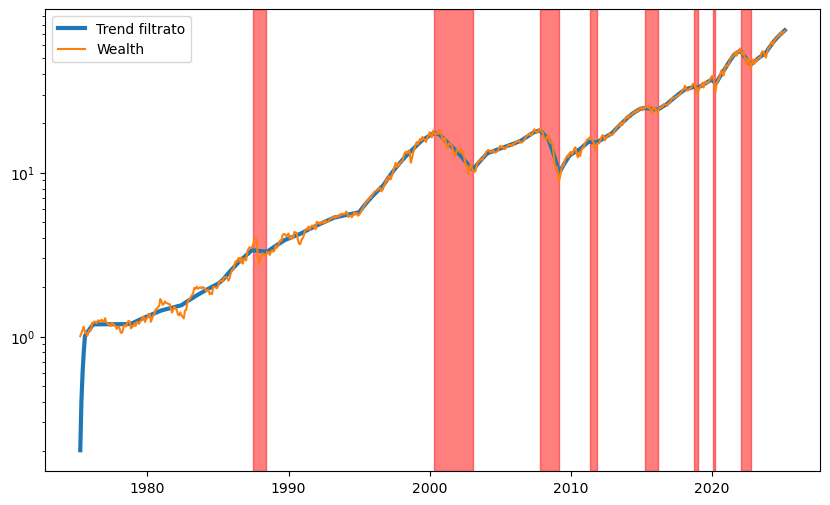

In [7]:
#apply trend_filter
trend = trend_filtering(wealth,10)

dfreturns = pd.DataFrame({'ret': ret, 'wealth': wealth, 'trend': trend})
dfreturns['regime'] = dfreturns['trend'].diff(1).fillna(method='bfill').apply(lambda x: 1 if x > 0 else 0)
dfreturns['group'] = (dfreturns['regime'] != dfreturns['regime'].shift()).cumsum()

plt.figure(figsize=(10, 6))
plt.plot(dates, trend, label='Trend filtrato', linewidth=3)
plt.plot(dates, wealth, label='Wealth')

for row in dfreturns[dfreturns['regime'] == 0].groupby('group').apply(lambda x: (x.index[0], x.index[-1])).reset_index(drop=True):
    plt.axvspan(row[0],row[1], alpha=0.5, color='red')


plt.yscale('log')
plt.legend()



In [8]:
dfreturns['regime'].value_counts(normalize=True)

regime
1    0.836667
0    0.163333
Name: proportion, dtype: float64

In [9]:
transition_matrix = pd.crosstab(dfreturns['regime'], dfreturns['regime'].shift(-1), normalize='index').rename_axis(index=None, columns=None)
transition_matrix.round(2)

,0.0,1.0
0,0.92,0.08
1,0.02,0.98


## Modello di portafoglio basato sui scenari

Ora che abbiamo le informazioni relativamente ai regimi vogliamo usare queste informazioni al fine di migliorare il bilanciamento del nostro portafoglio chiameremo questo scenario based portfolio.

Dobbiamo inserire questi stati nelle nostre formule del rendimento atteso e della varianza, il rendimento atteso può essere definito nel seguente modo, impostiamo $S$ l'insieme di tutti i possibili stati con $\pi_s$ la probabilità di ogni singolo stato

$$
    Z_1 = \sum_s^S \pi_s \times w_j \times \left(1 + r_{(j,s)} \right)
$$

Impostiamo la varianza come 


$$
    Z_2 = \sum_s^S \pi_s \times \left( (1 + r_{(j,s)}) - Z_1 \right)^2
$$



## Modellazione del portafoglio a due regimi

Una corretta modellazione a due regimi ci permette di identificare quegli assett che durante i periodi di crisi si comportano meglio, infatti i modelli a singolo regime non riescono a gestire le code lunghe in cui gli eventi estremi si presentano con una  [frequenza maggiore rispetto alla curva normale](https://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html).

![Fat tail](./img/fatqq.png)


visualizziamo dunque il grafico q-q plot per analizzare i rendimenti mensilizzati dell'indice sp500 a regime singolo e a doppio regime

In [10]:
import scipy

def Q_Q_plot(serie,name):
    plt.figure(figsize=(12,9))
    res = scipy.stats.probplot(serie, plot=plt)
    plt.title('Q-Q Plot of Asset: ' + name, fontsize=10)
    plt.ylabel('Returns')
    plt.show()

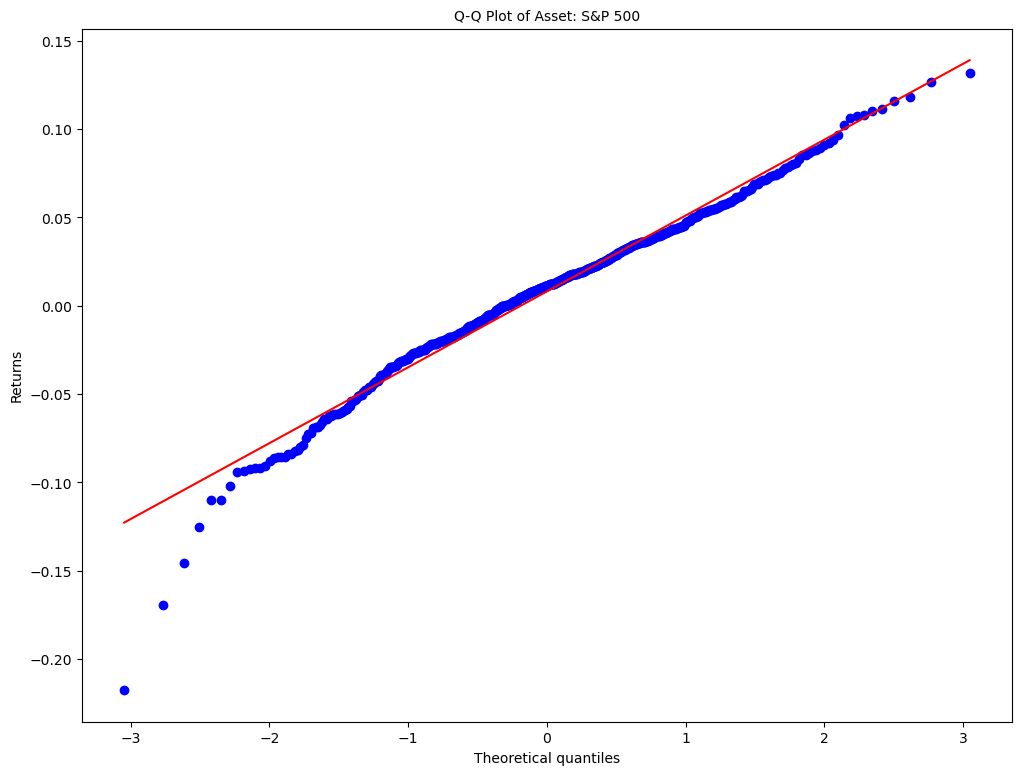

In [11]:
Q_Q_plot(dfreturns['ret'],'S&P 500')

Visualizziamo ora il grafico in regime normale

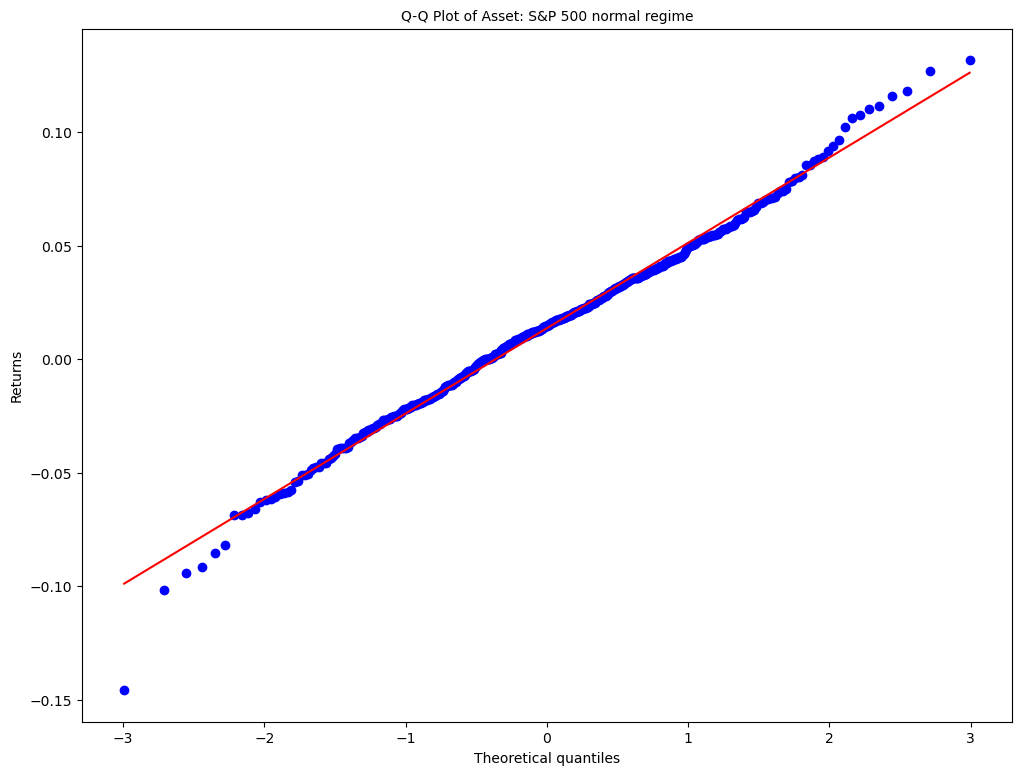

In [12]:
growth = dfreturns['regime'] == 1
Q_Q_plot(dfreturns[growth]['ret'],'S&P 500 normal regime')

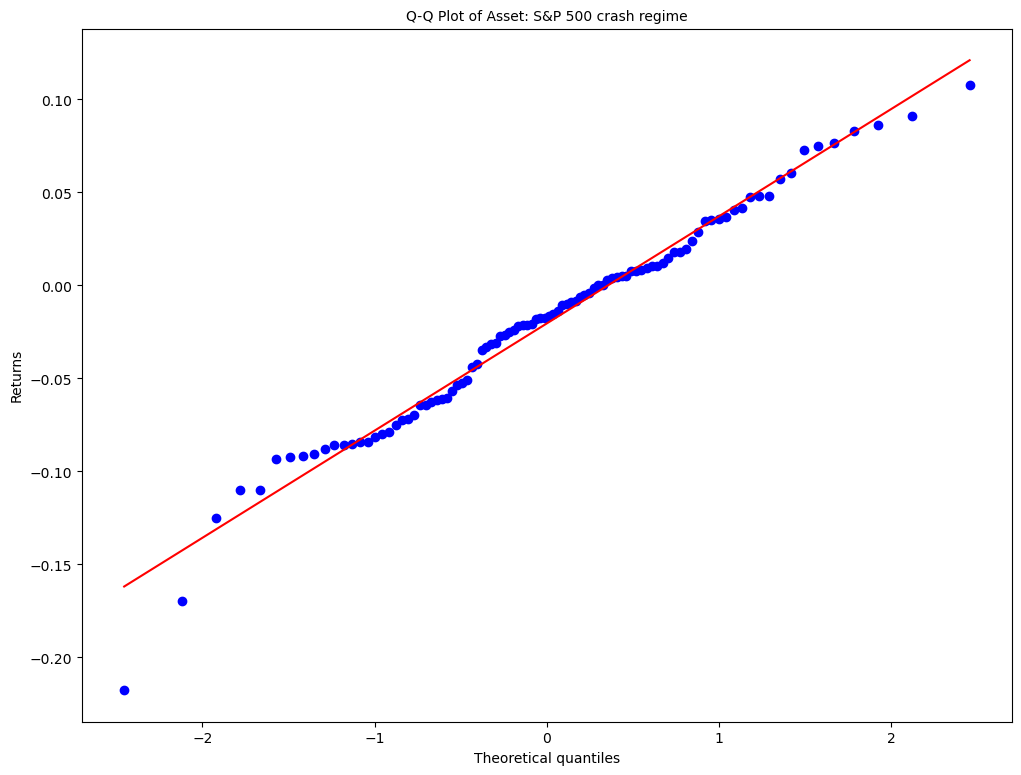

In [13]:
crash = dfreturns['regime'] == 0
Q_Q_plot(dfreturns[crash]['ret'],'S&P 500 crash regime')

Visualizziamo anche la distribuzione cumulativa delle due distribuzioni:

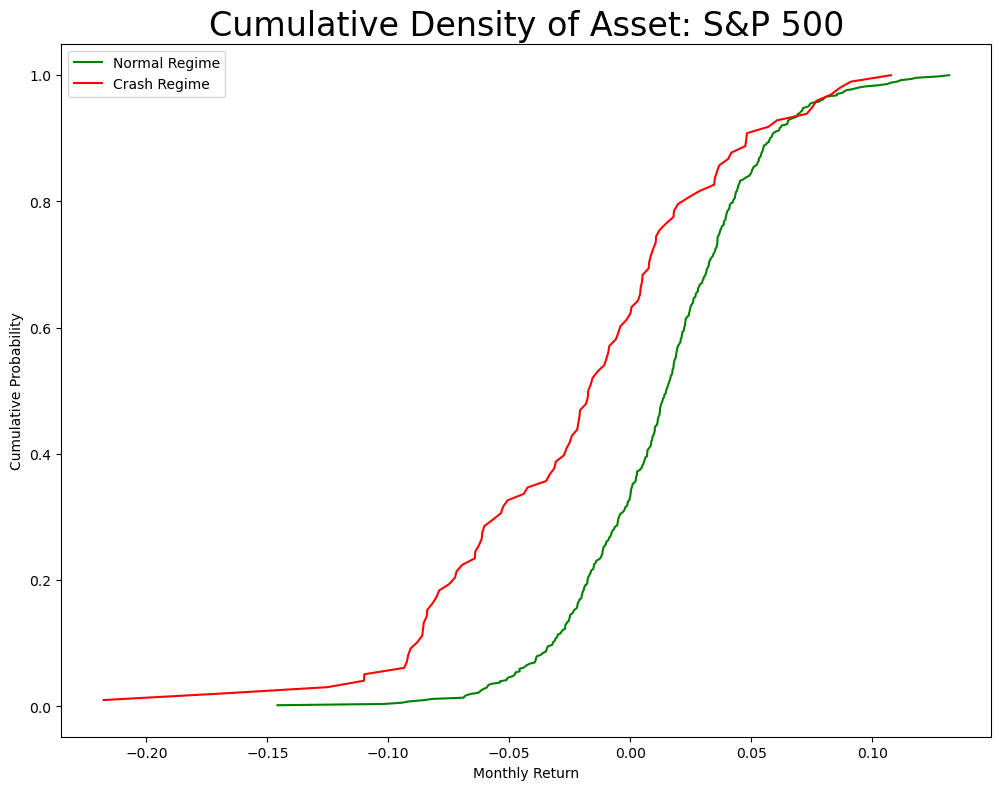

In [14]:
def cdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y
    


def regime_plot(ret_g,ret_c,column):
    plt.figure(figsize=(12,9))
    
    xg,yg = cdf(ret_g)
    xc,yc = cdf(ret_c)
    
    plt.plot(xg, yg, color='green',label='Normal Regime')
    plt.plot(xc, yc, color='red',label='Crash Regime')
    
    plt.xlabel('Monthly Return')
    plt.ylabel('Cumulative Probability')
    plt.legend(loc='upper left')
    plt.title('Cumulative Density of Asset: ' + column, fontsize=24)
    plt.show()
    
    
ret_g = dfreturns[growth]['ret']
ret_c = dfreturns[crash]['ret']

regime_plot(ret_g,ret_c,'S&P 500')

    

Vediamo ora cosa succede con la divisione per regimi che abbiamo scelto useremo i seguenti asset 

* Azionario americano
* Azionario mondiale
* Materie prime
* Obbligazioni


Evidenzieremo il fatto che durante i regimi di crash le correlazioni degli assett aumentano

![correlation](./img/regime.gif)



Iniziamo con il caricamento dei dati


In [15]:
columns = ['US Equities','World Equities','US Treasuries','High Yield','Real Estate','Commodities','Corp Bonds','T-bill']
regime = 'Regime-5'


asset_data = pd.read_csv('./data/Assets.csv',index_col=0, header=0)

In particolare in questo dataset notiamo le colonne:

* Regime-5 calcolato sull'sp 500 con $\lambda$ pari a 16
* Regime-7 calcolato sull'sp 500 con $\lambda$ pari a 14
* Regime-9 calcolato sull'sp 500 con $\lambda$ pari a 10


prenderemo come riferimento la colonna Regime-5, con questi parametri applichiamo il calcolo della frontiera efficiente con periodo singolo e a due regimi


Visualizziamo il grafico q-q plot dei vari assett al cambiare del regime

In [16]:
import ipywidgets as widgets
from ipywidgets import interact

In [17]:
d = widgets.Dropdown(
    options=columns,
    value=columns[0],
    description='Asset:',
    disabled=False,
)


def plot_function(selection):
    Q_Q_plot(asset_data[selection],selection)

interact(plot_function,selection=d)

interactive(children=(Dropdown(description='Asset:', options=('US Equities', 'World Equities', 'US Treasuries'…

<function __main__.plot_function(selection)>

In [18]:
d = widgets.Dropdown(
    options=columns,
    value=columns[0],
    description='Asset:',
    disabled=False,
)


def plot_function(selection):
    growth =  asset_data[regime] > 0
    crash =   asset_data[regime] < 0
    
    ret_g = asset_data[growth][selection]
    ret_c = asset_data[crash][selection]
    
    regime_plot(ret_g,ret_c,selection)
    

interact(plot_function,selection=d)

interactive(children=(Dropdown(description='Asset:', options=('US Equities', 'World Equities', 'US Treasuries'…

<function __main__.plot_function(selection)>

Eseguiamo ora la stima della frontiera efficiente a singolo regime e doppio regime

In [19]:
# Set Parameters
n_scen = 10000
m_freq = 12
r_bar = np.arange(0.035,0.115,0.005)

In [20]:
ret = asset_data[columns]

growth =  asset_data[regime] > 0
crash =   asset_data[regime] < 0
    
ret_g = asset_data[growth][columns]
ret_c = asset_data[crash][columns]


In [21]:
from scipy.stats import gmean

def geo_return(values):
    return gmean(values + 1) - 1
    

Estraiamo la matrice di covarianza e il rendimento medio a singolo regime

In [22]:
Q_all = np.cov(ret.T) * m_freq
r_1 = (1+geo_return(ret)) ** m_freq - 1
r_annual = r_1.reshape(-1,1)

facciamo lo stesso lavoro con il doppio regime

In [23]:
r_g = (1+geo_return(ret_g)) ** m_freq - 1
r_c = (1+geo_return(ret_c)) ** m_freq - 1

n_g = int(n_scen*ret_g.shape[0] / ret.shape[0])

Q_g = np.cov(ret_g.T) * m_freq
Q_c = np.cov(ret_c.T) * m_freq

Creiamo una simulazione con `n_scen` scenari a singolo regime

In [24]:
r_all_1 = np.random.multivariate_normal(r_1, Q_all, n_scen)

Calcoliamo ora la frontiera efficiente a singolo regime con i dati a disposizione

In [25]:
from optimization import LongOnlyConstraint,FullInvestmentConstraint,ReturnConstraint,MinVarianceOpt
from utils import est_return, est_vol

def efficient_frontier(assets,r, Q, r_bar, line = 'xb-'):
    
    x_limits = (0, 15)
    y_limits = (2, 11.5)
    
    n_asset = r_annual.size
    weight_vec = np.zeros((len(r_bar),n_asset))
    risk_port = np.zeros(len(r_bar))
    ret_port = np.zeros(len(r_bar))
    
    
    for i, r_curr in enumerate(r_bar):
        print("* For the case r-bar = ", round(r_curr*100,3), "%:")
        
        cons = [LongOnlyConstraint(), FullInvestmentConstraint(),ReturnConstraint(r, r_curr)]
        
        o = MinVarianceOpt(assets, cons, Q)
        o.solve()
        
        if o.has_solution: 
            w = o.variables['w'].value
            weight_vec[i,:] = w
            ret_port[i] = est_return(w, r)
            risk_port[i] = est_vol(w, Q)
        else:
            print("NOTE: solution to this r-bar will be dropped!")
            
    plt.figure(figsize=(12,9))    
    plt.plot(risk_port*100, ret_port*100, line)
    plt.xlabel("Risk (%)")
    plt.ylabel("Nominal Return (%)") 
    
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    
    DF_Alloc_R = pd.DataFrame(np.round(weight_vec.T,3))
    DF_Alloc_R.index = assets
    DF_Alloc_R.columns = [str(round(r * 100, 1)) +"%" for r in r_bar]
    
    return DF_Alloc_R
        
        
    

* For the case r-bar =  3.5 %:
Solution 5.7e-05 result status optimal
* For the case r-bar =  4.0 %:
Solution 9.1e-05 result status optimal
* For the case r-bar =  4.5 %:
Solution 0.00018 result status optimal
* For the case r-bar =  5.0 %:
Solution 0.00033 result status optimal
* For the case r-bar =  5.5 %:
Solution 0.00054 result status optimal
* For the case r-bar =  6.0 %:
Solution 0.00081 result status optimal
* For the case r-bar =  6.5 %:
Solution 0.0011 result status optimal
* For the case r-bar =  7.0 %:
Solution 0.0015 result status optimal
* For the case r-bar =  7.5 %:
Solution 0.002 result status optimal
* For the case r-bar =  8.0 %:
Solution 0.0027 result status optimal
* For the case r-bar =  8.5 %:
Solution 0.0038 result status optimal
* For the case r-bar =  9.0 %:
Solution 0.0053 result status optimal
* For the case r-bar =  9.5 %:
Solution 0.0076 result status optimal
* For the case r-bar =  10.0 %:
Solution 0.011 result status optimal
* For the case r-bar =  10.5 

,3.5%,4.0%,4.5%,5.0%,5.5%,6.0%,6.5%,7.0%,7.5%,8.0%,8.5%,9.0%,9.5%,10.0%,10.5%,11.0%
US Equities,-0.000,0.006,0.016,0.026,0.035,0.045,0.055,0.064,0.081,0.138,0.191,0.283,0.389,0.495,0.637,0.836
World Equities,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
US Treasuries,0.002,0.082,0.163,0.244,0.325,0.406,0.487,0.568,0.625,0.372,0.079,-0.000,0.000,0.000,-0.000,-0.000
High Yield,0.011,0.052,0.086,0.120,0.154,0.189,0.223,0.257,0.295,0.284,0.250,0.285,0.344,0.403,0.363,0.164
Real Estate,0.002,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000
Commodities,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
Corp Bonds,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.207,0.480,0.433,0.267,0.102,-0.000,-0.000
T-bill,0.986,0.859,0.735,0.610,0.485,0.360,0.235,0.110,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000


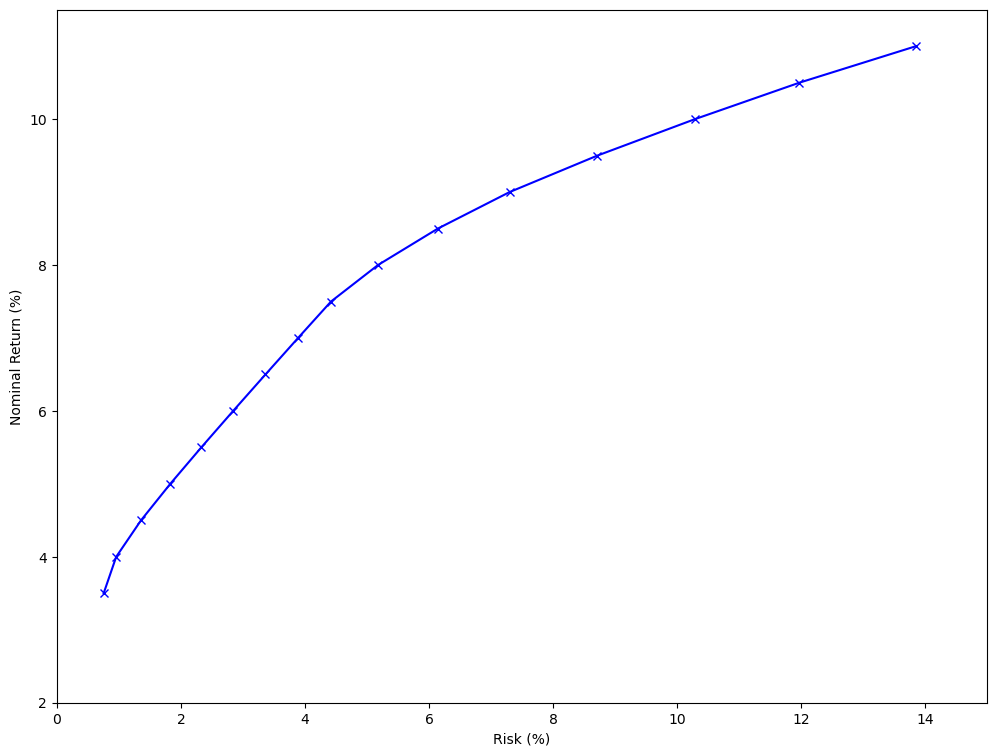

In [26]:
efficient_frontier(ret.columns,r_annual, Q_all, r_bar)

Passiamo ora alla simulazione a due regimi

In [27]:
s_1 = np.random.multivariate_normal(r_g, Q_g, n_g)
s_2 = np.random.multivariate_normal(r_c, Q_c, n_scen-n_g)
r_all_2 = np.vstack((s_1,s_2))

In [28]:
Q_2 = np.cov(r_all_2.T)
mu_2 = np.mean(r_all_2, axis=0)

In [29]:
r_annual_2 = mu_2.reshape(-1,1)

* For the case r-bar =  3.5 %:
Solution 6.4e-05 result status optimal
* For the case r-bar =  4.0 %:
Solution 0.0001 result status optimal
* For the case r-bar =  4.5 %:
Solution 0.0002 result status optimal
* For the case r-bar =  5.0 %:
Solution 0.00036 result status optimal
* For the case r-bar =  5.5 %:
Solution 0.00057 result status optimal
* For the case r-bar =  6.0 %:
Solution 0.00084 result status optimal
* For the case r-bar =  6.5 %:
Solution 0.0012 result status optimal
* For the case r-bar =  7.0 %:
Solution 0.0015 result status optimal
* For the case r-bar =  7.5 %:
Solution 0.002 result status optimal
* For the case r-bar =  8.0 %:
Solution 0.003 result status optimal
* For the case r-bar =  8.5 %:
Solution 0.0045 result status optimal
* For the case r-bar =  9.0 %:
Solution 0.0066 result status optimal
* For the case r-bar =  9.5 %:
Solution 0.0094 result status optimal
* For the case r-bar =  10.0 %:
Solution 0.013 result status optimal
* For the case r-bar =  10.5 %:


,3.5%,4.0%,4.5%,5.0%,5.5%,6.0%,6.5%,7.0%,7.5%,8.0%,8.5%,9.0%,9.5%,10.0%,10.5%,11.0%
US Equities,0.000,-0.000,0.008,0.015,0.023,0.031,0.039,0.047,0.079,0.144,0.207,0.288,0.396,0.503,0.608,0.709
World Equities,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000
US Treasuries,0.024,0.113,0.203,0.293,0.384,0.474,0.564,0.654,0.684,0.442,0.160,-0.000,-0.000,-0.000,0.000,-0.000
High Yield,0.000,0.042,0.071,0.100,0.129,0.158,0.186,0.215,0.238,0.178,0.099,0.047,0.029,0.011,0.000,0.000
Real Estate,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
Commodities,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000
Corp Bonds,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.236,0.534,0.665,0.575,0.486,0.392,0.291
T-bill,0.976,0.845,0.718,0.591,0.464,0.337,0.210,0.084,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000


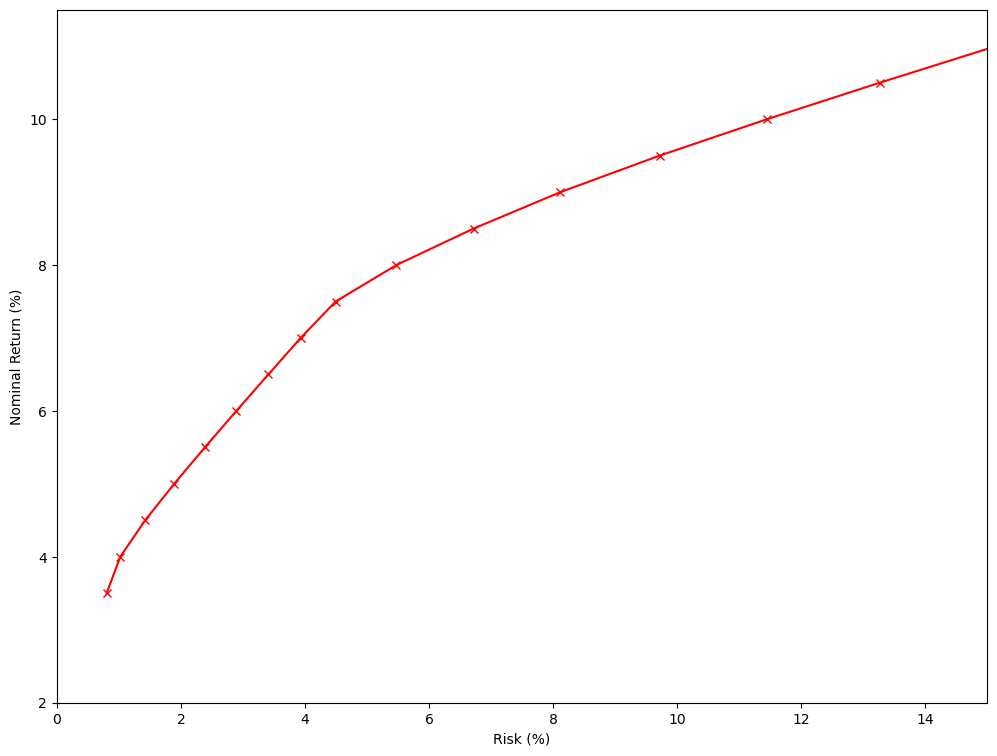

In [30]:
efficient_frontier(ret.columns,r_annual_2, Q_2, r_bar,'xr-')

Possiamo confrontare i due risultati vediamo che il rendimento a doppio regime è più basso (come ovviamente ci aspettavamo) all'aumentare del rischio

![optimization](./img/optimization.gif)



Possiamo anche effettuare una simulazione per misurare l'andamento del nostro investimento creiamo una funzione che data la durata dell'investimento e i dati dei due regimi restituisca la serie dei rendimenti voluta creiamo come primo passo una funzione che ci dia il regime partendo dalla matrice di transizione

In [31]:
import numpy as np

def generate_state_sequence(transition_matrix, initial_state, num_steps):
    states = [initial_state]
    current_state = initial_state

    for _ in range(num_steps):
        current_state = np.random.choice(range(transition_matrix.shape[1]), p=transition_matrix[current_state])
        states.append(current_state)

    return np.array(states)

In [32]:
asset_data[regime] = asset_data[regime].apply(lambda x: 1 if x > 0 else 0)
transition_matrix = pd.crosstab(asset_data[regime], asset_data[regime].shift(-1), normalize='index').rename_axis(index=None, columns=None).T

In [33]:
transition_matrix.round(2)

,0,1
0.0,0.92,0.01
1.0,0.08,0.99


In [34]:
years = 10
state = 1


seq = generate_state_sequence(transition_matrix,state, years * m_freq)
seq

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

da questa sequenza creiamo una serie di rendimenti le distribuzioni normali a più regimi inizio con il creare la lista dei rendimenti ai vari regimi

In [35]:
mu = []
Q = []

ret = asset_data[columns]
for val in pd.Series(asset_data[regime].unique()).sort_values():
    reg = asset_data[regime] == val
    mu.append(geo_return(ret[reg]) + 1)
    Q.append(np.cov(ret[reg].T) * m_freq)

In [36]:
def regime_asset(transition_matrix, initial_state, num_steps,mu,Q):
    sequence = generate_state_sequence(transition_matrix,initial_state,num_steps)
    
    generated_vectors = []
    for state in sequence:
        vector = np.random.multivariate_normal(mu[state], Q[state])
        generated_vectors.append(vector)
    
    return np.array(generated_vectors)
    
    

In [37]:
regime_asset(transition_matrix,state, years * m_freq,mu,Q)

array([[0.92319448, 0.91433795, 1.01187632, 1.03961866, 0.98197642,
        0.9056712 , 1.02773169, 1.00338847],
       [0.87246094, 0.98172681, 1.05113272, 0.97064167, 1.08353351,
        1.12848831, 1.0152187 , 0.99985458],
       [1.06046491, 1.04441118, 1.00802301, 0.85608203, 0.99621825,
        0.76888607, 0.95748526, 1.00208227],
       [0.84401697, 0.94888159, 0.98033256, 0.974707  , 0.9961905 ,
        0.82197084, 0.91613511, 0.98784308],
       [0.97040363, 0.92607122, 0.95095618, 0.95018356, 0.65107755,
        0.87929782, 0.99425023, 0.99434854],
       [1.15978295, 1.17491122, 0.97232297, 0.91452949, 1.06440954,
        0.99177518, 0.92257073, 0.9986443 ],
       [1.19115985, 1.04436927, 0.97823251, 1.06122658, 0.95555241,
        1.01225324, 0.99054882, 1.00656077],
       [1.05599008, 0.84221474, 0.97059133, 1.06239682, 1.1246857 ,
        0.88951416, 0.98008526, 1.00603769],
       [1.07057791, 1.08875409, 0.98905856, 1.0195998 , 1.12864145,
        0.94417988, 1.011452

Questa funzione restituisce i rendimenti per una singola simulazione dobbiamo dunque generare un insieme di simulazioni

In [38]:
def asset_simulation(transition_matrix, initial_state,mu,Q, n_scenarios=10000, n_years=10):
    num_steps = n_years * m_freq
    
    r_all = np.zeros((num_steps + 1, len(mu[0]), n_scenarios))
    for i in range(n_scenarios):
        r_all[:,:,i] = regime_asset(transition_matrix,state, num_steps,mu,Q)
    
    return r_all
    

In [39]:
r_all_10 = asset_simulation(transition_matrix, state,mu,Q)
np.mean(np.mean(r_all_10,axis=0),axis=1)

array([1.00976366, 1.00784925, 1.00511597, 1.00744344, 1.00774633,
       1.00382893, 1.00613204, 1.00281546])

In [40]:
holdings = np.array([.3, 0, .2, .2, .1, 0, .15, .05])

def fund_simulation(holding,asset_return,rebalance=4):
    n_months, n_assets, n_scenarios = asset_return.shape
    
    wealth_path = np.zeros((n_scenarios, n_months))
    
    for i in range(n_scenarios):
        holdings_each = holdings
        for j in range(n_months):
            holdings_each = holdings_each * asset_return[j,:,i]
            if j%rebalance == 0:
                asset_temp = np.sum(holdings_each)
                holdings_each = asset_temp * holdings
        
        wealth_path[i:] = np.cumprod(np.sum(holdings_each))
    
    return wealth_path
        
        
    

In [41]:
result = fund_simulation(holdings,r_all_10)

Text(0, 0.5, 'Frequenza')

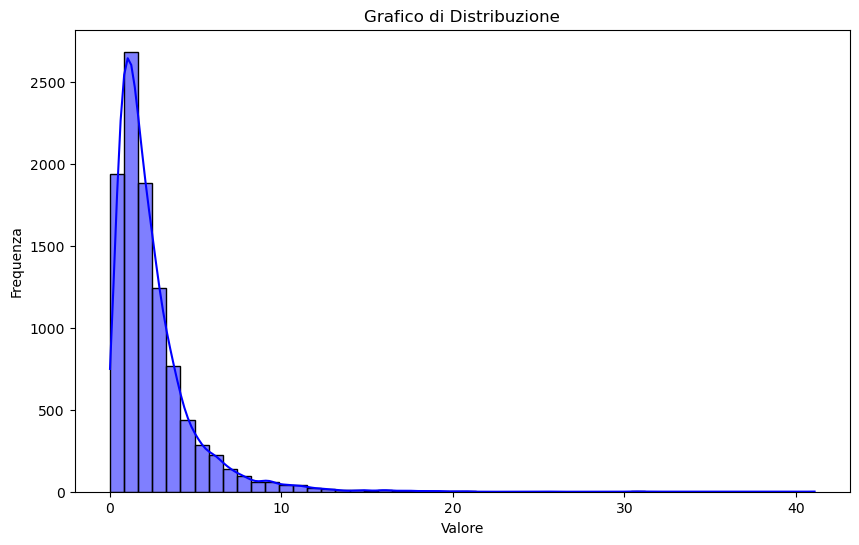

In [42]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(result[:,-1], kde=True, bins=50, color='blue')

# Aggiungi titolo e etichette
plt.title('Grafico di Distribuzione')
plt.xlabel('Valore')
plt.ylabel('Frequenza')




In [43]:
np.median(result[:,-1])

1.8068042531600454

In [44]:
np.sum(result[:,-1] < 1) / len(result[:,-1])

0.2457